## Load and Explore the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('H:/Preperation/SQL Projects data/marketing_AB.csv')

In [6]:
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [7]:
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [9]:
#rename column names to standard
data.drop(['Unnamed: 0','user id'], axis=1,inplace=True)
data.columns = data.columns.str.replace(" ", "_", regex=True)

In [11]:
# show unique values for categorical columns
print("Unique categorical values:")
columns = data.columns.drop('total_ads')
for column in columns:
    print( column, ": ", data[column].unique())

Unique categorical values:
test_group :  ['ad' 'psa']
converted :  [False  True]
most_ads_day :  ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday']
most_ads_hour :  [20 22 18 10 14 13 19 11 12 16 21  3 23  4  8  0  2 15  1  6 17  7  9  5]


In [12]:
data.describe()

,total_ads,most_ads_hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


In [13]:
# Check for missing values
print(data.isnull().sum())

test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64


In [14]:
# Convert 'converted' column to numeric (1 for True, 0 for False)
data['converted'] = data['converted'].astype(int)

In [17]:
# Separate data for the experimental group (ad) and control group (psa)
ad_group = data[data['test_group'] == 'ad']
psa_group = data[data['test_group'] == 'psa']

In [18]:
# Calculate conversion rates
ad_conversion_rate = ad_group['converted'].mean() * 100
psa_conversion_rate = psa_group['converted'].mean() * 100

In [19]:
# Calculate attributable impact
attributable_impact = ad_conversion_rate - psa_conversion_rate

In [21]:
# Calculate average ads seen in the experimental group
avg_ads_seen = ad_group['total_ads'].mean()

In [22]:
# Print results
print(f"Ad Group Conversion Rate: {ad_conversion_rate:.2f}%")
print(f"PSA Group Conversion Rate: {psa_conversion_rate:.2f}%")
print(f"Attributable Impact: {attributable_impact:.2f}%")
print(f"Average Ads Seen (Experimental Group): {avg_ads_seen:.2f}")

Ad Group Conversion Rate: 2.55%
PSA Group Conversion Rate: 1.79%
Attributable Impact: 0.77%
Average Ads Seen (Experimental Group): 24.82


## Compare Group Performance

### Perform a Two-Proportion Z-Test

In [23]:
from statsmodels.stats.proportion import proportions_ztest

# Count of conversions and sample sizes for each group
ad_conversions = ad_group['converted'].sum()
psa_conversions = psa_group['converted'].sum()

ad_size = len(ad_group)
psa_size = len(psa_group)

# Perform the z-test
counts = [ad_conversions, psa_conversions]
nobs = [ad_size, psa_size]
z_stat, p_value = proportions_ztest(counts, nobs)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the groups.")

Z-statistic: 7.3701
P-value: 0.0000
Reject the null hypothesis: There is a significant difference between the groups.


### Analyze Ad Exposure

<Figure size 720x432 with 0 Axes>

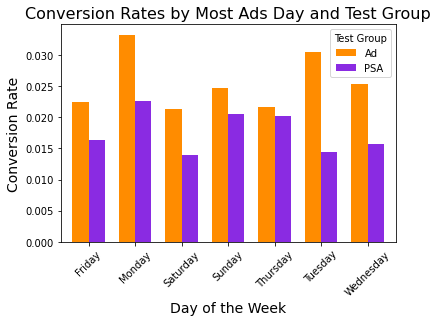

In [32]:
conversion_rate_by_day = data.groupby(['most_ads_day', 'test_group'])['converted'].mean().unstack()

plt.figure(figsize=(10, 6))
conversion_rate_by_day.plot(kind='bar', stacked=False, color=['#FF8C00', '#8A2BE2'], width=0.7)
plt.title('Conversion Rates by Most Ads Day and Test Group', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Test Group', labels=['Ad', 'PSA'])
plt.show()

### Analyze Most Active Day and Hour



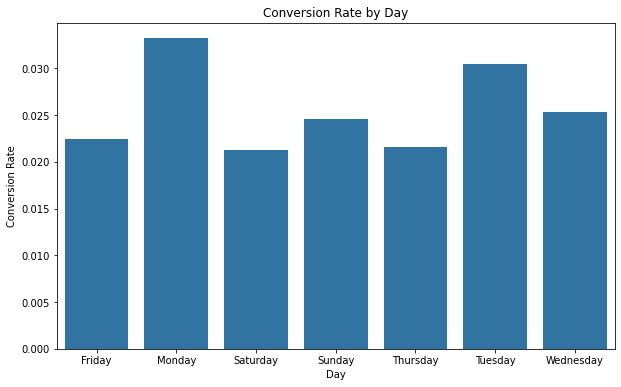

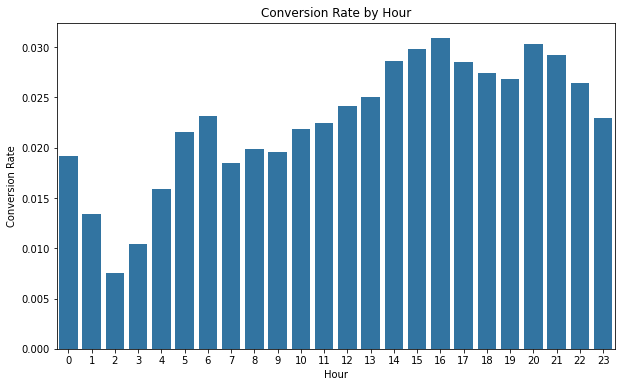

In [29]:
# Group by 'most ads day' and calculate conversion rates
day_conversion = ad_group.groupby('most_ads_day')['converted'].mean().reset_index()

# Group by 'most ads hour' and calculate conversion rates
hour_conversion = ad_group.groupby('most_ads_hour')['converted'].mean().reset_index()

# Plot conversion rates by day
plt.figure(figsize=(10, 6))
sns.barplot(x='most_ads_day', y='converted', data=day_conversion)
plt.title('Conversion Rate by Day')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')
plt.show()

# Plot conversion rates by hour
plt.figure(figsize=(10, 6))
sns.barplot(x='most_ads_hour', y='converted', data=hour_conversion)
plt.title('Conversion Rate by Hour')
plt.xlabel('Hour')
plt.ylabel('Conversion Rate')
plt.show()

### Chi-Square Test for Independence

Tests whether the Ad campaign influenced the likelihood of conversion

In [34]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['test_group'], data['converted'])

# Perform the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant association between the groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between the groups.")

Chi-Square Statistic: 54.0058
P-value: 0.0000
Reject the null hypothesis: There is a significant association between the groups.


- The Chi-Square test results suggest that there is a significant association between the test group (Ad vs. PSA) and the converted outcome.

- The extremely low p-value (0.0000) indicates that the likelihood of this association occurring by random chance is virtually zero.

### Independent Samples T-Test

Compare the average number of ads seen or other continuous metrics between the two groups.
Confirms whether the difference in means (e.g., conversion rates) is statistically significant.

In [35]:
from scipy.stats import ttest_ind

# Compare the average number of ads seen between the two groups
t_stat, p_value = ttest_ind(ad_group['total_ads'], psa_group['total_ads'])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the means.")

T-statistic: 0.2139
P-value: 0.8306
Fail to reject the null hypothesis: There is no significant difference in the means.


- The t-test results suggest that there is no statistically significant difference in the average conversion rates between the Ad and PSA groups.

- The high p-value (0.8306) indicates that the observed difference in means could easily occur by random chance.

### Bootstrapping

Quantifies the impact of the Ad campaign and provides a confidence interval.

In [38]:
# Function to calculate the difference in conversion rates
def bootstrap_diff(data, n_bootstrap=1000):
    diffs = []
    for _ in range(n_bootstrap):
        sample = data.sample(frac=1, replace=True)  # Resample with replacement
        ad_rate = sample[sample['test_group'] == 'ad']['converted'].mean()
        psa_rate = sample[sample['test_group'] == 'psa']['converted'].mean()
        diffs.append(ad_rate - psa_rate)
    return diffs

# Perform bootstrapping
bootstrap_diffs = bootstrap_diff(data)

# Calculate the 95% confidence interval
ci_lower = np.percentile(bootstrap_diffs, 2.5)
ci_upper = np.percentile(bootstrap_diffs, 97.5)

print(f"95% Confidence Interval for Difference in Conversion Rates: ({ci_lower:.4f}, {ci_upper:.4f})")


95% Confidence Interval for Difference in Conversion Rates: (0.0059, 0.0093)


- The bootstrapping results suggest that the Ad campaign led to a 0.59% to 0.93% increase in conversion rates compared to the PSA group.

- Since the confidence interval does not include zero, this indicates that the Ad campaign had a positive and statistically significant impact on conversions.